### Student Activity: Financial Forecasting Part I

This program executes a single simulation of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of historical daily returns derived from the sample mean and standard deviation.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
##from dotenv import load_dotenv
##load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': '9a6b3b30-c141-40f3-8a95-6e9a58a92f55',
     'marginable': True,
     'name': 'Medley Capital Corporation 6.50% Notes due 2021',
     'shortable': False,
     'status': 'active',
     'symbol': 'MCX',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': 'bfd95f49-1392-4002-990c-8fcb1d374f61',
     'marginable': True,
     'name': 'Crawford & Company Class B',
     'shortable': True,
     'status': 'active',
     'symbol': 'CRD.B',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NASDAQ',
     'id': '2ac633b5-b3a7-4ba6-975d-f0f1e12dd1e4',
     'marginable': True,
     'name': 'Adobe Inc. Common Stock',
     'shortable': True,
     'status': 'active',
     'symbol': 'ADBE',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     '

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,NUGT
1,CNCR
2,CODX
3,TDOC
4,ONEM
5,CRAI
6,SPWH
7,MEXX_deprecated
8,SDPI
9,KREF


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for TSLA
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                    
                             open    high      low    close    volume
2019-11-04 00:00:00-05:00  314.80  321.94  309.260  317.425   8579754
2019-11-05 00:00:00-05:00  319.62  323.51  316.118  317.160   6308975
2019-11-06 00:00:00-05:00  318.00  326.72  314.500  326.700   7748529
2019-11-07 00:00:00-05:00  329.14  341.50  328.020  335.390  14148570
2019-11-08 00:00:00-05:00  334.50  337.46  332.500  337.120   5966814

### Drop Extraneous Levels and Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-11-04,317.425
2019-11-05,317.160
2019-11-06,326.700
2019-11-07,335.390
2019-11-08,337.120


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-11-04,NaN
2019-11-05,-0.000835
2019-11-06,0.030079
2019-11-07,0.026599
2019-11-08,0.005158


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.006724657991054272

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.06056369619711004

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize the simulated prices list with the last closing price of TSLA
simulated_tsla_prices = [tsla_last_price]

# Simulate the returns for 252 * 3 trading days
for i in range(num_trading_days):
    # Calculate the simulated price using the last price within the list
    simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
    # Append the simulated price to the list
    simulated_tsla_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
simulated_price_df = pd.DataFrame({
    "Simulated TSLA Prices": simulated_tsla_prices
})

# Print head of DataFrame
simulated_price_df.head()

,Simulated TSLA Prices
0,514.560000
1,553.953378
2,552.726982
3,584.505335
4,600.108925


### Plot the Simulated Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3) of Trading Days

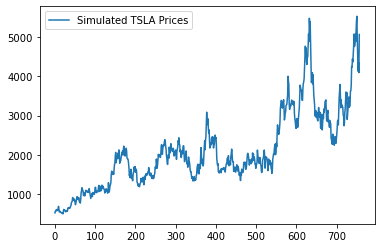

In [11]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a (252 * 3) trading day simulation
simulated_price_df.plot()

### Calculate Daily Returns of Simulated Stock Prices for TSLA

In [12]:
# Use the `pct_change` function to calculate daily returns of simulated stock prices for TSLA
simulated_daily_returns = simulated_price_df.pct_change()
simulated_daily_returns.head()

,Simulated TSLA Prices
0,NaN
1,0.076557
2,-0.002214
3,0.057494
4,0.026695


### Calculate the Cumulative Returns of Simulated Stock Prices for TSLA

In [13]:
# Use the `cumprod` function to calculate the cumulative returns of simulated stock prices for TSLA
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
simulated_cumulative_returns.head()

,Simulated TSLA Prices
0,NaN
1,1.076557
2,1.074174
3,1.135932
4,1.166256


### Calculate the Cumulative Profits/Losses of Simulated Stock Prices for TSLA

In [14]:
# Multiply an initial investment by the cumulative returns of simulative stock prices to
# return the progression of cumulative returns in terms of money
initial_investment = 10000
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,Simulated TSLA Prices
0,NaN
1,10765.574036
2,10741.740165
3,11359.323203
4,11662.564611


### Plot the Cumulative Profits/Losses of `$10,000` in TSLA Over the Next 3 Years (252 * 3) of Trading Days

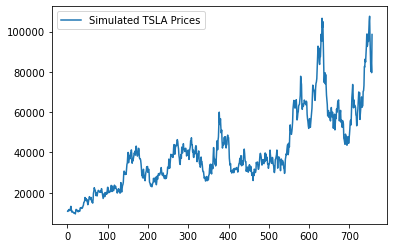

In [15]:
# Use the 'plot' function to create a chart of the cumulative profits/losses
cumulative_pnl.plot()